# Getting Started with Datacube Stats
| Author(s):  | [Arapaut Sivaprasad](mailto:Sivaprasad.Arapaut@ga.gov.au)|
|----------|----------------|
| Created: | May 17, 2018 |
| Last edited: | May 18, 2018 |
| Acknowledgements: | Imam Alam|

## Data Cube Statistics Tools
Data Cube Statistics is a an application used to calculate large scale temporal statistics on data stored using an Open Data Cube (ODC) installation. It provides a command line application which uses a YAML configuration file to specify the data range and statistics to calculate.

In [104]:
%matplotlib inline
import datacube
import matplotlib.pyplot as plt
from skimage import exposure
import numpy as np
from collections import namedtuple

import yaml
from datacube_stats import StatsApp
from datacube import Datacube
import matplotlib.gridspec as gridspec

import sys
import os
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts'))
import DEAPlotting
import DEADataHandling

## Configuration File
The entire config for this application resides in a YAML file as given below. More details about its components later...

In [105]:
def main_0():
    config_yaml = """
    sources:
      - product: ls5_nbar_albers
        measurements: [red, green, blue]
        group_by: solar_day

    date_ranges:
        start_date: 2011-01-01
        end_date: 2011-12-01

    storage:
        # this driver enables in-memory computation
        driver: xarray

        crs: EPSG:3577
        tile_size:
            x: 40000.0
            y: 40000.0
        resolution:
            x: 25
            y: -25
        chunking:
            x: 200
            y: 200
            time: 1
        dimension_order: [time, y, x]

    computation:
        chunking:
            x: 800
            y: 800

    input_region:
          longitude: [149.05, 149.17]
          latitude: [-35.25, -35.35]

    output_products:
        - name: nbar_mean
          statistic: simple
          statistic_args:
               reduction_function: mean
    """
    return config_yaml
#    print(config_yaml)
    # or manually creating a config dictionary works too

In [121]:
def main():
    config_yaml = """
    sources:
      - product: ls5_nbar_albers
        measurements: [blue, green, red, nir, swir1, swir2]
        group_by: solar_day
        source_filter:
          product: ls5_level1_scene
          gqa_iterative_mean_xy: [0, 1]
        masks:
          - product: ls5_pq_albers
            measurement: pixelquality
            group_by: solar_day
            fuse_func: datacube.helpers.ga_pq_fuser
            flags:
              contiguous: True
              cloud_acca: no_cloud
              cloud_fmask: no_cloud
              cloud_shadow_acca: no_cloud_shadow
              cloud_shadow_fmask: no_cloud_shadow
              blue_saturated: False
              green_saturated: False
              red_saturated: False
              nir_saturated: False
              swir1_saturated: False
              swir2_saturated: False
      - product: ls7_nbar_albers
        measurements: [blue, green, red, nir, swir1, swir2]
        group_by: solar_day
        source_filter:
          product: ls7_level1_scene
          gqa_iterative_mean_xy: [0, 1]
        masks:
          - product: ls7_pq_albers
            measurement: pixelquality
            group_by: solar_day
            fuse_func: datacube.helpers.ga_pq_fuser
            flags:
              contiguous: True
              cloud_acca: no_cloud
              cloud_fmask: no_cloud
              cloud_shadow_acca: no_cloud_shadow
              cloud_shadow_fmask: no_cloud_shadow
              blue_saturated: False
              green_saturated: False
              red_saturated: False
              nir_saturated: False
              swir1_saturated: False
              swir2_saturated: False
          
    date_ranges:
        start_date: 2011-01-01
        end_date: 2011-02-01

    storage:
        # this driver enables in-memory computation
        driver: xarray

        crs: EPSG:3577
        tile_size:
            x: 40000.0
            y: 40000.0
        resolution:
            x: 25
            y: -25
        chunking:
            x: 200
            y: 200
            time: 1
        dimension_order: [time, y, x]

    computation:
        chunking:
            x: 800
            y: 800

    input_region:
          longitude: [149.05, 149.17]
          latitude: [-35.25, -35.35]

    output_products:
        - name: nbar_mean
          statistic: simple
          statistic_args:
               reduction_function: mean
    """
    return config_yaml


### Create and load the config
Instead of a YAML format as above, the whole data can be specified as a dictionary object (see below). The advantage of YAML is that it is more human readable.

In [122]:
    config_yaml = main()
    config = yaml.load(config_yaml)
    print(yaml.dump(config, indent=4))
    print(config)


computation:
    chunking: {x: 800, y: 800}
date_ranges: {end_date: 2011-02-01, start_date: 2011-01-01}
input_region:
    latitude: [-35.25, -35.35]
    longitude: [149.05, 149.17]
output_products:
-   name: nbar_mean
    statistic: simple
    statistic_args: {reduction_function: mean}
sources:
-   group_by: solar_day
    masks:
    -   flags: {blue_saturated: false, cloud_acca: no_cloud, cloud_fmask: no_cloud,
            cloud_shadow_acca: no_cloud_shadow, cloud_shadow_fmask: no_cloud_shadow,
            contiguous: true, green_saturated: false, nir_saturated: false, red_saturated: false,
            swir1_saturated: false, swir2_saturated: false}
        fuse_func: datacube.helpers.ga_pq_fuser
        group_by: solar_day
        measurement: pixelquality
        product: ls5_pq_albers
    measurements: [blue, green, red, nir, swir1, swir2]
    product: ls5_nbar_albers
    source_filter:
        gqa_iterative_mean_xy: [0, 1]
        product: ls5_level1_scene
-   group_by: solar_day
 

### Define the datacube stats application

In [123]:
dc = Datacube()
app = StatsApp(config, dc.index)

### Generate the tasks
Do not know yet what the tasks are. Will update it as I learn more!

This example is taking a simple mean of the data spread over the date range. There are other methods that are more complex.

In [124]:
#print('generating tasks')
tasks = app.generate_tasks()


### Run the tasks

In [125]:
query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'time':('2017-01-01', '2017-01-15')
        }
ds = dc.load(product='ls8_nbar_albers', group_by='solar_day', **query)

In [126]:
def calculate_boundingbox(ds):
    Extent = namedtuple('Extent', ['boundingbox'])
    BoundingBox = namedtuple('BoundingBox', ['left', 'bottom', 'right', 'top'])
    left = ds.x.min().item()
    right = ds.x.max().item()
    top = ds.y.min().item()
    bottom=ds.y.max().item()
    return Extent(boundingbox=BoundingBox(left=left, bottom=bottom, right=right, top=top))

In [127]:
    print('Running tasks. May take some time. Be patient!')
    for task in tasks:
        # this method is only available for the xarray output driver
        output = app.execute_task(task)
        ds = output.result['nbar_mean']
#    print(dir(ds))
    ds.attrs['crs'] = 'EPSG:3577'
    ds.attrs['extent'] = calculate_boundingbox(ds)


Running tasks. May take some time. Be patient!


In [128]:
ds.extent.boundingbox

BoundingBox(left=1542337.5, bottom=-3953087.5, right=1554612.5, top=-3965562.5)

### Plot it as a grid first

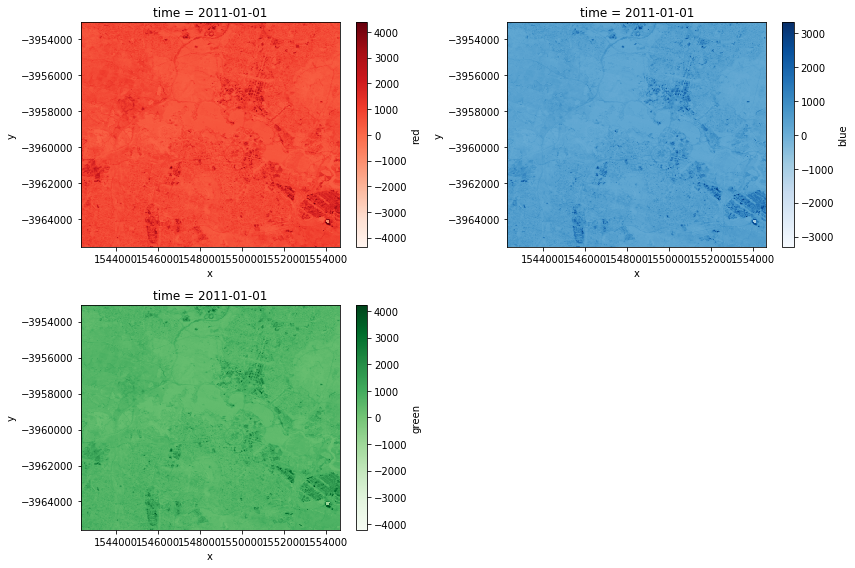

In [129]:
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
ds.red.isel(time=0).plot(cmap='Reds')

ax2=plt.subplot(gs[1,0])
ds.green.isel(time=0).plot(cmap='Greens')

ax3=plt.subplot(gs[0,1])
ds.blue.isel(time=0).plot(cmap='Blues')

plt.tight_layout()
plt.show()

### Plot it as three bands

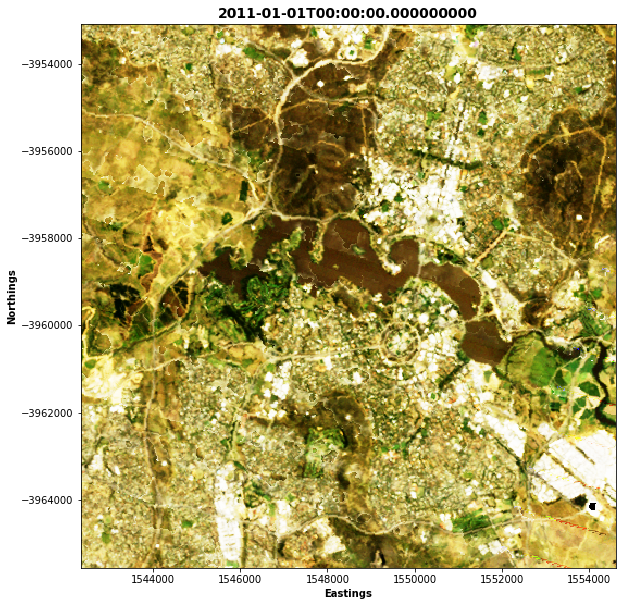

In [130]:
DEAPlotting.three_band_image(ds, bands = ['red', 'green', 'blue'], time = 0, contrast_enhance=True);